> # Chapter 15. Prediction
---




### 1.  Correlation 


### 2.  The Regression Line 


### 3.  The Method of Least Squares 


### 4.  Least Squares Regression 


### 5.   Visual Diagnostics 


### 6.   Numerical Diagnostics 




In [10]:
# HIDDEN
from datascience import *
import numpy as np

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
np.set_printoptions(threshold=50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  


+ Data science에서 중요한 task 중 하나는 ___prediction___ 이다.
 - 즉, 미래(시간적) 혹은 알거나 보지 못한 상황에 대한 결과를 예측하는 것이다.
 - 앞서 평균부모키로부터 자식의 키를 예측해 보았다.
 - 이 장에서는  prediction에 관한 보다 자세한 개념과 방법을 배워보자.

> ###  Correlation
---
+ Scattor diagram이 얼마나 직선에 밀접해 있는지를 나타내는 척도
+ Linear assocation 
+ 하이브리드 차 정보에 관한 다음 데이터를 이용해 공부해 보자.

In [11]:
hybrid = Table.read_table('https://raw.githubusercontent.com/data-8/materials-sp18/master/lec/hybrid.csv')
hybrid

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater
Insight,2002,19137,9.71,53,Two Seater
Alphard,2003,38084.8,8.33,40.46,Minivan
Insight,2003,19137,9.52,53,Two Seater
Civic,2003,14071.9,8.62,41,Compact


+ vehicle: 자동차 모델명 
+ year: 제조년도 
+ msrp: 제조사 제시 소매가 (2013년 달러)
+ acceleration: 가속 비율 (km per hour per second)
+ mpg: 연료효율 (miles per gallon)
+ class: 자동차 분류


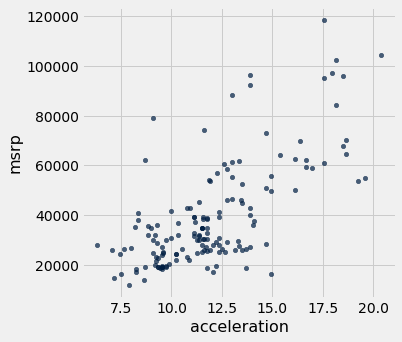

In [12]:
hybrid.scatter('acceleration', 'msrp')

+ 성능(acceleration)이 좋을수록 가격(msrp)이 비싸다.
 - 즉, 양의 상관관계가 있다.
 

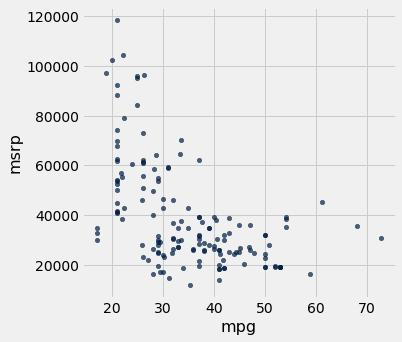

In [13]:
hybrid.scatter('mpg', 'msrp')

+ 연료효율성(mpg)이 나쁠수록 가격이 높다.
 - 즉, 음의 상관관계가 있다.
 - 좋은 성능일수록 연료효율성이 나빠진다.
 - 그런데 다소 상관성이 직선이 아니라 곡선으로 보인다.

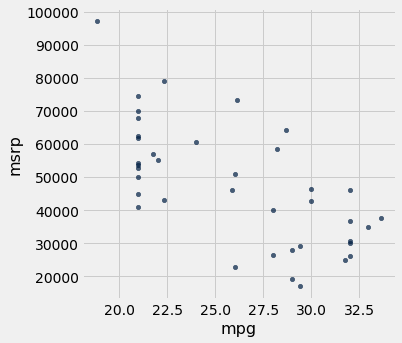

In [14]:
suv = hybrid.where('class', 'SUV')
suv.scatter('mpg', 'msrp')

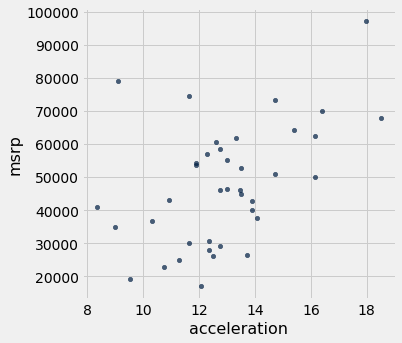

In [15]:
suv.scatter('acceleration', 'msrp')

+ SUV 차량에 대한 상관성 결과는 보다 직선에 가까워 보인다.
+ 상관성을 정량화시킬 필요가 있다.
+ 데이터 사이의 차이를 일반화시킬 수 있도록 지난 시간에 배운 standard unit으로 바꿔서 진행해 보자.

In [0]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  


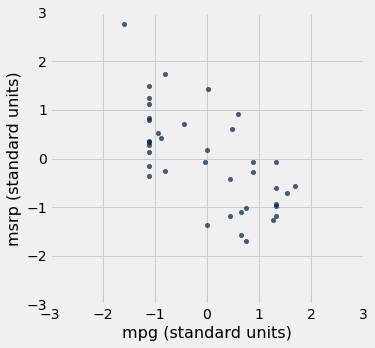

In [17]:
Table().with_columns(
    'mpg (standard units)',  standard_units(suv.column('mpg')), 
    'msrp (standard units)', standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

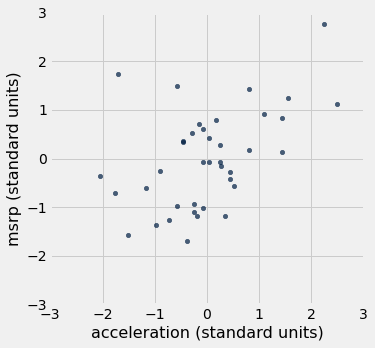

In [18]:
Table().with_columns(
    'acceleration (standard units)', standard_units(suv.column('acceleration')), 
    'msrp (standard units)',         standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

이제 correlation을 도입해 보자.

> The correlation coefficient ($r$; 상관계수)
---
+ the strength of the linear relationship between two variables
+ 흔히 correlation으로 줄여쓰며 $r$로 표기한다.
 - The correlation coefficient $r$ is a number between -1 and 1.
 - $r$ measures the extent to which the scatter plot clusters around a straight line.
 - $r = 1$ if the scatter diagram is a perfect straight line sloping upwards, and $r = -1$ if the scatter diagram is a perfect straight line sloping downwards.

+ r_scatter() 함수는 예제 scatter를 보여준다.

In [0]:
def r_scatter(r, n=1000):
    plots.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, n)
    z = np.random.normal(0, 1, n)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.scatter(x, y)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)

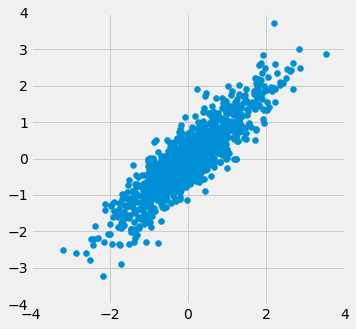

In [20]:
r_scatter(0.9)


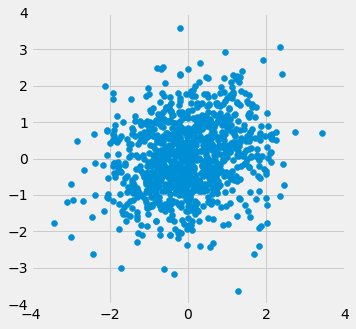

In [21]:
r_scatter(0.25)

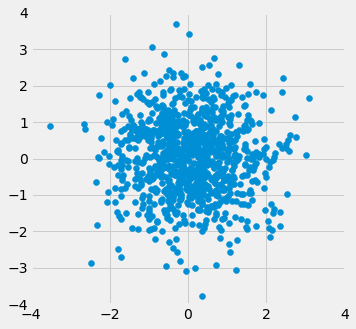

In [22]:
r_scatter(0)

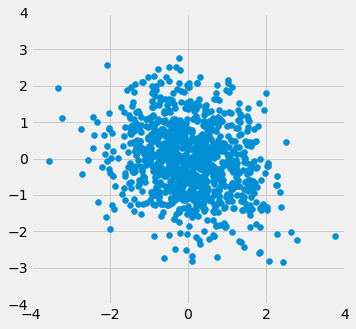

In [23]:
r_scatter(-0.25)

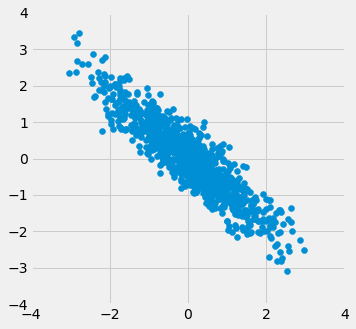

In [24]:
r_scatter(-0.9)

Formula for $r$:

$r=\frac{Cov(X,Y)}{\sigma_{X} \sigma_{Y}}$

where $Cov(X,Y)=E(XY)-E(X)\cdot E(Y)$.

+ 두 변수 모두 standard units으로 측정된다면 $r=E(XY)$이다.

+ 다음 예제를 통해 살펴보자.


In [25]:
x = np.arange(1, 7, 1)
y = make_array(2, 3, 1, 5, 2, 7)
t = Table().with_columns(
        'x', x,
        'y', y
    )
t

x,y
1,2
2,3
3,1
4,5
5,2
6,7


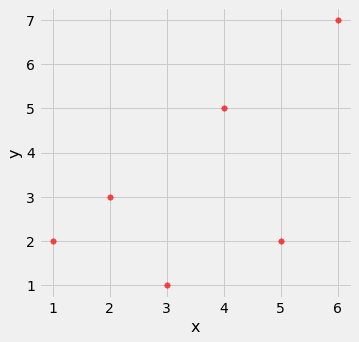

In [26]:
t.scatter(0, 1, s=30, color='red')

__Step 1.__ Convert each variable to standard units.

In [27]:
t_su = t.with_columns(
        'x (standard units)', standard_units(x),
        'y (standard units)', standard_units(y)
    )
t_su

x,y,x (standard units),y (standard units)
1,2,-1.46385,-0.648886
2,3,-0.87831,-0.162221
3,1,-0.29277,-1.13555
4,5,0.29277,0.811107
5,2,0.87831,-0.648886
6,7,1.46385,1.78444


__Step 2.__ Multiply each pair of standard units.

In [28]:
t_product = t_su.with_column('product of standard units', t_su.column(2) * t_su.column(3))
t_product

x,y,x (standard units),y (standard units),product of standard units
1,2,-1.46385,-0.648886,0.949871
2,3,-0.87831,-0.162221,0.142481
3,1,-0.29277,-1.13555,0.332455
4,5,0.29277,0.811107,0.237468
5,2,0.87831,-0.648886,-0.569923
6,7,1.46385,1.78444,2.61215


__Step 3.__ $r$ is the average of the products computed in Step 2.

In [29]:
r = np.mean(t_product.column(4))
r

0.6174163971897709

> Properties of $r$
---
+ $r$ 은 두 축의 방향을 바꾸어도 변하지 않는다. (즉, $X$와 $Y$를 바꾸어도 변하지 않는다.)

Correlation 정의에 따라 다음과 같은 함수를 정의할 수 있다.

In [0]:
def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

In [31]:
correlation(t, 'x', 'y')


0.6174163971897709

In [32]:
correlation(t, 'y', 'x')

0.6174163971897709

In [33]:
correlation(suv, 'mpg', 'msrp')

-0.6667143635709919

In [34]:
correlation(suv, 'acceleration', 'msrp')

0.48699799279959155

+ Correlation은 Linear Association을 의미한다. 

+ Correlation이 Causation을 뜻하지 않는다.


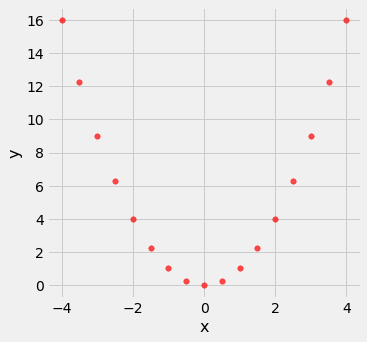

In [35]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')


In [36]:
correlation(nonlinear, 'x', 'y')

0.0

+ Correlation은 Outliers에 의해 영향을 크게 받을 수 있다.


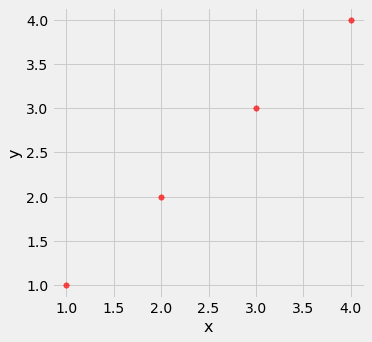

In [37]:
line = Table().with_columns(
        'x', make_array(1, 2, 3, 4),
        'y', make_array(1, 2, 3, 4)
    )
line.scatter('x', 'y', s=30, color='r')

In [38]:
correlation(line, 'x', 'y')

1.0

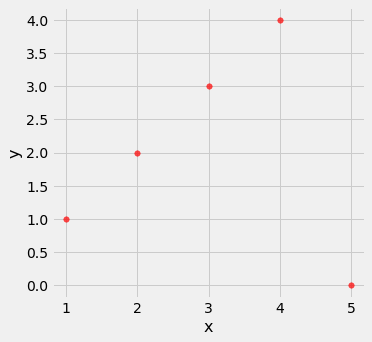

In [39]:
outlier = Table().with_columns(
        'x', make_array(1, 2, 3, 4, 5),
        'y', make_array(1, 2, 3, 4, 0)
    )
outlier.scatter('x', 'y', s=30, color='r')

In [40]:
correlation(outlier, 'x', 'y')

0.0

> Ecological Correlations Should be Interpreted with Care.

In [41]:
sat2014 = Table.read_table('https://raw.githubusercontent.com/data-8/materials-sp18/master/lec/sat2014.csv').sort('State')
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
Alabama,6.7,547,538,532,1617
Alaska,54.2,507,503,475,1485
Arizona,36.4,522,525,500,1547
Arkansas,4.2,573,571,554,1698
California,60.3,498,510,496,1504
Colorado,14.3,582,586,567,1735
Connecticut,88.4,507,510,508,1525
Delaware,100,456,459,444,1359
District of Columbia,100,440,438,431,1309
Florida,72.2,491,485,472,1448


+ Participation Rate : SAT 시험에 참가한 학생 수 비율
+ Critical Reading, Math, Writing : 3개 과목 평균점수

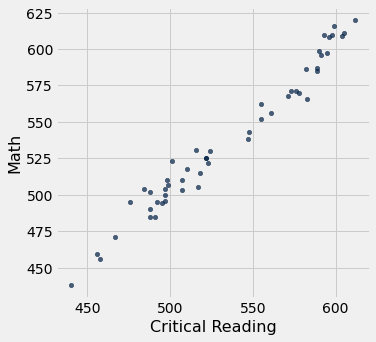

In [42]:
sat2014.scatter('Critical Reading', 'Math')

In [43]:
correlation(sat2014, 'Critical Reading', 'Math')

0.9847558411067434

+ 상관계수가 매우 높지만 state's average 값에 대한 상관성을 말한다.
+ 개별학생들 전체에 관한 상관계수를 조사하면 더 낮을 것이다. 

<img src="https://drive.google.com/uc?id=1oKycJuscYJlaL7krF9_J8AuSgQor9kJH" width="500">

> ### The Regression Line
---
+ $r$은 scattor plot의 점들이 어떤 직선에 얼마나 군집되었는지를 표현
+ 이 때 어떤 직선은 어떻게 구하는가? (단 $r<1$이라고 가정)

+ 아래 $r=0.5$인 예를 보자.
+ 그리고 slope(기울기)가 1인 붉은색 직선(즉 45도)을 같이 그려보자.

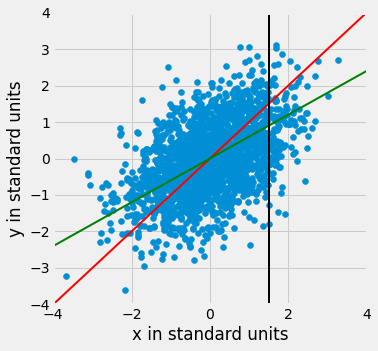

In [44]:
r_scatter(0.5, 2000)
plots.plot([-4,4],[-4,4], color='r', lw=2)
plots.plot([-4,4],[-4*0.6,4*0.6], color='g', lw=2)
plots.xlabel('x in standard units')
plots.ylabel('y in standard units');
plots.plot([1.5,1.5], [-4,4], color='k', lw=2)


+ 45도 기울기는 검은 선을 고려할 때 중앙에 위치해 보이지 않는다.
+ 기울기는 $r$로 표현된다. (아래 그림)

<img src="https://drive.google.com/uc?id=15lyGaZ9S2ZSw-3fo1itsiLxqyeVBwZkD" width="500">


+ 위 관계로부터 다음과 같이 regression 직선의 slope(기울기)와 intercept(절편)를 구할 수 있다.
 - slope = $r \frac{\sigma_y}{\sigma_x}$
 - intercept = $\mu_y - slope \cdot \mu_x$

In [0]:
def correlation(t, label_x, label_y):
    return np.mean(standard_units(t.column(label_x))*standard_units(t.column(label_y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

+ Galton의 데이터에 이용해 보자.

In [47]:
galton = Table.read_table('https://raw.githubusercontent.com/data-8/materials-sp18/master/lec/galton.csv')
heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
    )
heights

MidParent,Child
75.43,73.2
75.43,69.2
75.43,69
75.43,69
73.66,73.5
73.66,72.5
73.66,65.5
73.66,65.5
72.06,71
72.06,68


In [48]:
galton_r = correlation(heights, 'MidParent', 'Child')
galton_r

0.32094989606395924

In [49]:
galton_slope = slope(heights, 'MidParent', 'Child')
galton_intercept = intercept(heights, 'MidParent', 'Child')
galton_slope, galton_intercept

(0.637360896969479, 22.63624054958975)

In [50]:
heights_with_predictions = heights.with_column(
    'Regression Prediction', galton_slope*heights.column('MidParent') + galton_intercept
)
heights_with_predictions

MidParent,Child,Regression Prediction
75.43,73.2,70.7124
75.43,69.2,70.7124
75.43,69,70.7124
75.43,69,70.7124
73.66,73.5,69.5842
73.66,72.5,69.5842
73.66,65.5,69.5842
73.66,65.5,69.5842
72.06,71,68.5645
72.06,68,68.5645


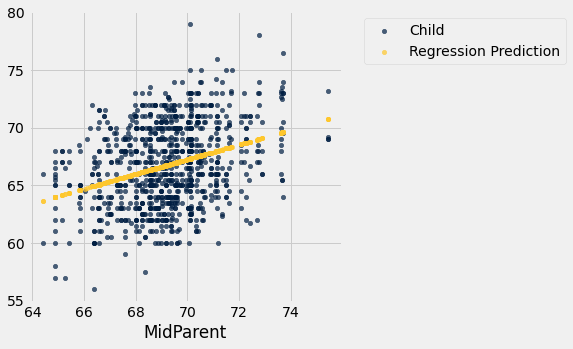

In [51]:
heights_with_predictions.scatter('MidParent')

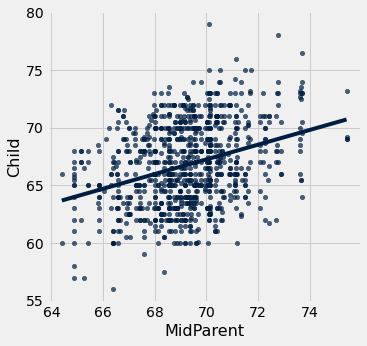

In [52]:
heights.scatter('MidParent', fit_line=True)

+ regression line을 통해 prediction을 수행할 수 있다.
+ 부모평균키가 1인치 커지면 자녀키는 0.637인치 증가한다.

> ### The Method of Least Squares
---
+ 보다 일반적인 설명법을 이해해 보자.
+ $x$가 주어졌을 때 예측값 $\hat{y}$와 실제값 $y$ 사이에 오차가 존재한다.
 - $error = y - \hat{y}$
+ 예측이 정확하다면 오차는 0에 가까워질 것이다.

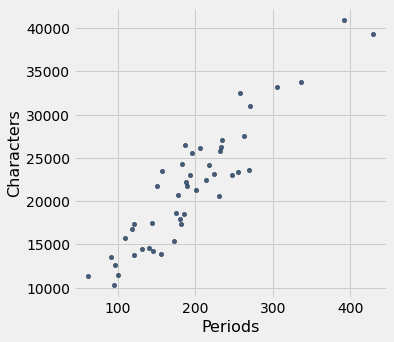

In [53]:
little_women = Table.read_table('https://raw.githubusercontent.com/data-8/materials-sp18/master/lec/little_women.csv')
little_women = little_women.move_to_start('Periods')
little_women.scatter('Periods', 'Characters')

In [54]:
correlation(little_women, 'Periods', 'Characters')

0.9229576895854816

+ 선형 관계가 매우 강하다.

In [0]:
def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b


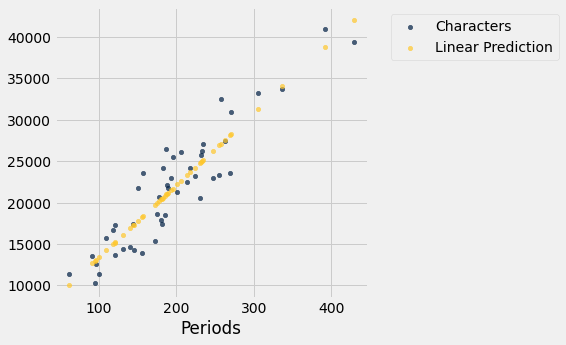

In [56]:
lw_with_predictions = little_women.with_column('Linear Prediction', fit(little_women, 'Periods', 'Characters'))
lw_with_predictions.scatter('Periods')

In [0]:
actual = lw_with_predictions.column('Characters')
predicted = lw_with_predictions.column('Linear Prediction')
errors = actual - predicted

In [58]:
lw_with_predictions.with_column('Error', errors)

Periods,Characters,Linear Prediction,Error
189,21759,21183.6,575.403
188,22148,21096.6,1051.38
231,20558,24836.7,-4278.67
195,25526,21705.5,3820.54
255,23395,26924.1,-3529.13
140,14622,16921.7,-2299.68
131,14431,16138.9,-1707.88
214,22476,23358,-882.043
337,33767,34056.3,-289.317
185,18508,20835.7,-2327.69


+ 다음 그래프를 통해 오차의 의미를 더 잘 이해해보자.

In [0]:
lw_reg_slope = slope(little_women, 'Periods', 'Characters')
lw_reg_intercept = intercept(little_women, 'Periods', 'Characters')

In [0]:
sample = [[131, 14431], [231, 20558], [392, 40935], [157, 23524]]
def lw_errors(slope, intercept):
    little_women.scatter('Periods', 'Characters')
    xlims = np.array([50, 450])
    plots.plot(xlims, slope * xlims + intercept, lw=2)
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=2)

Slope of Regression Line:     87.0 characters per period
Intercept of Regression Line: 4745.0 characters


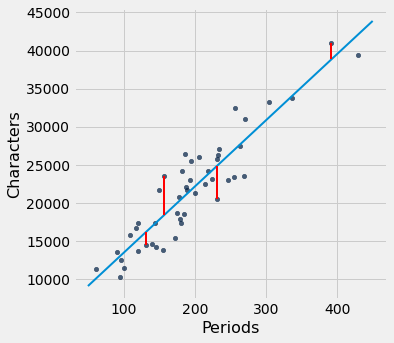

In [61]:
print('Slope of Regression Line:    ', np.round(lw_reg_slope), 'characters per period')
print('Intercept of Regression Line:', np.round(lw_reg_intercept), 'characters')
lw_errors(lw_reg_slope, lw_reg_intercept)


+ 다른 직선의 경우를 그려보자.
 - 오차가 더욱 커진다.

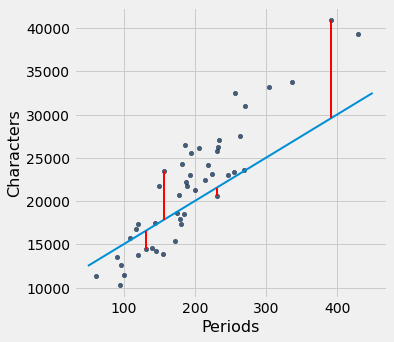

In [62]:
lw_errors(50, 10000)

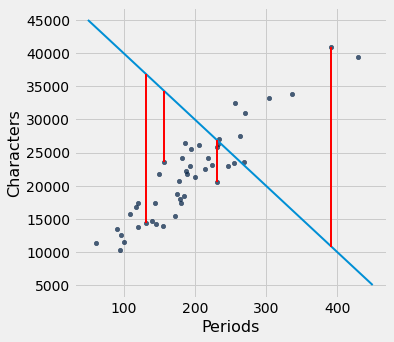

In [63]:
lw_errors(-100, 50000)

표준편차 정의의 개념과 비슷한 방식으로 

좋은 직선인지는 RMSE (Root Mean Squared Error)로 평가할 수 있다.

In [0]:
def lw_rmse(slope, intercept):
    lw_errors(slope, intercept)
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    fitted = slope * x + intercept
    mse = np.mean((y - fitted) ** 2)
    print("Root mean squared error:", mse ** 0.5)

Root mean squared error: 4322.167831766537


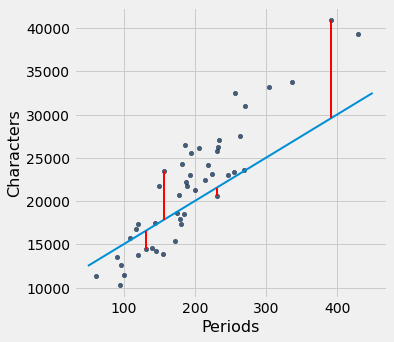

In [65]:
lw_rmse(50, 10000)

Root mean squared error: 16710.11983735375


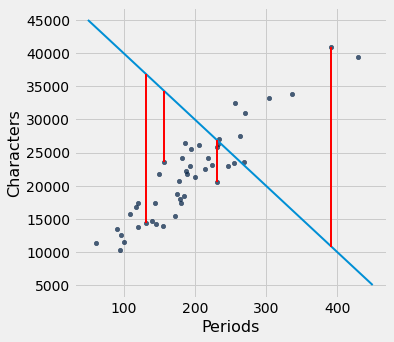

In [66]:
lw_rmse(-100, 50000)

Root mean squared error: 2715.5391063834586


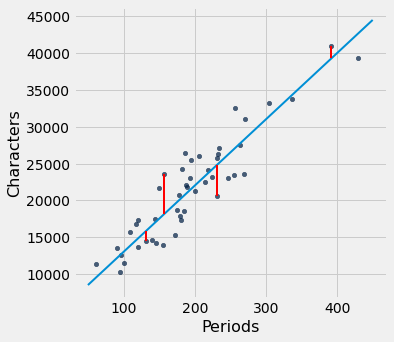

In [67]:
lw_rmse(90, 4000)

Root mean squared error: 2701.690785311856


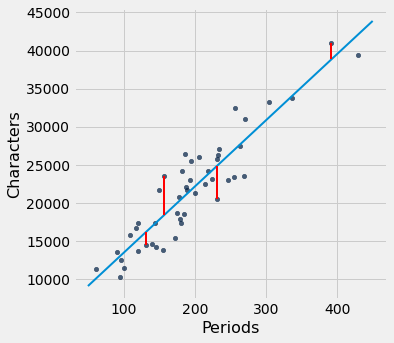

In [68]:
lw_rmse(lw_reg_slope, lw_reg_intercept)

+ RMSE를 최소화하는 직선이 regression line이다.


The regression line is the unique straight line that minimizes the mean squared error of estimation among all straight lines.

> ### Least Squares Regression
---
+ 다른 scattor plot에서 상관성을 고려해 보자.

In [69]:
shotput = Table.read_table('https://raw.githubusercontent.com/data-8/materials-sp18/master/lec/shotput.csv')
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


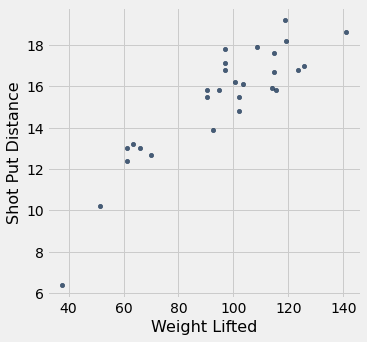

In [70]:
shotput.scatter('Weight Lifted')


+ 비록 럭비공모양은 아니지만 regression line이 존재한다.

In [71]:
slope(shotput, 'Weight Lifted', 'Shot Put Distance')

0.09834382159781997

In [72]:
intercept(shotput, 'Weight Lifted', 'Shot Put Distance')

5.959629098373952

+ minimize함수를 이용하여 regression line이 최소제곱합 오류인지를 확인해 보자.

In [0]:
def shotput_linear_mse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    fitted = any_slope*x + any_intercept
    return np.mean((y - fitted) ** 2)

In [74]:
minimize(shotput_linear_mse)

array([0.09834382, 5.95962911])

+ regression line이 최소제곱합(MSE) 오류를 가지는 직선이다.


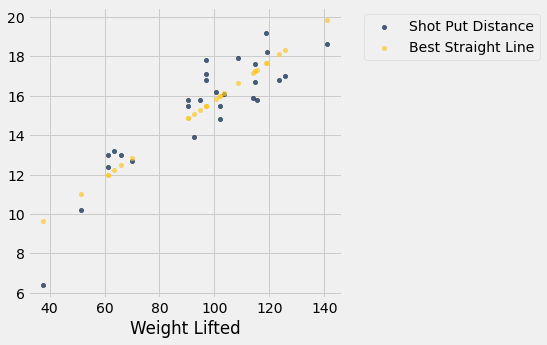

In [75]:
fitted = fit(shotput, 'Weight Lifted', 'Shot Put Distance')
shotput.with_column('Best Straight Line', fitted).scatter('Weight Lifted')


+ 만약 직선이 아니라면 어떨까?
+ 2차 함수(quadratic funtion)에 대해서 생각해 보자.
 - 다음 정의에서 'fitted' 계산에 주목

In [0]:
def shotput_quadratic_mse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    fitted = a*(x**2) + b*x + c
    return np.mean((y - fitted) ** 2)


In [77]:
best = minimize(shotput_quadratic_mse)
best

array([-1.04004838e-03,  2.82708045e-01, -1.53182115e+00])

+ 만약 x=100 이라면 예측값은?

In [78]:
(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

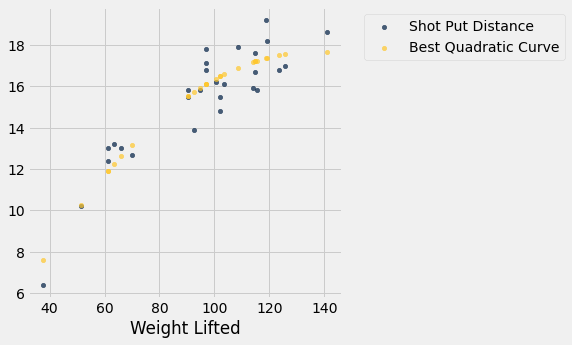

In [79]:
x = shotput.column(0)
shotput_fit = best.item(0)*(x**2) + best.item(1)*x + best.item(2)
shotput.with_column('Best Quadratic Curve', shotput_fit).scatter(0)

> ### Visual Diagnostics
---
+ Regression line이 적합한지 생각해 보아야 한다.
+ Residual (즉, 잔차)를 고려해 보자.

In [0]:
def residual(table, x, y):
    return table.column(y) - fit(table, x, y)

In [81]:
heights = heights.with_columns(
        'Fitted Value', fit(heights, 'MidParent', 'Child'),
        'Residual', residual(heights, 'MidParent', 'Child')
    )
heights

MidParent,Child,Fitted Value,Residual
75.43,73.2,70.7124,2.48763
75.43,69.2,70.7124,-1.51237
75.43,69,70.7124,-1.71237
75.43,69,70.7124,-1.71237
73.66,73.5,69.5842,3.91576
73.66,72.5,69.5842,2.91576
73.66,65.5,69.5842,-4.08424
73.66,65.5,69.5842,-4.08424
72.06,71,68.5645,2.43553
72.06,68,68.5645,-0.564467


In [0]:
def scatter_fit(table, x, y):
    table.scatter(x, y, s=15)
    plots.plot(table.column(x), fit(table, x, y), lw=4, color='gold')
    plots.xlabel(x)
    plots.ylabel(y)

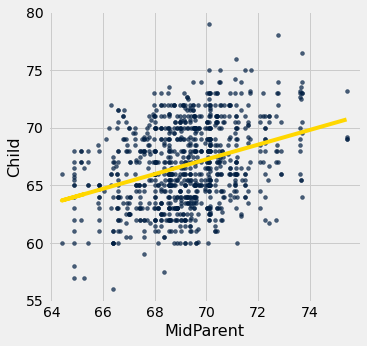

In [83]:
scatter_fit(heights, 'MidParent', 'Child')

+ $x$와 $residual$ 사이의 분포 상관성을 그려보자.

In [0]:
def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')


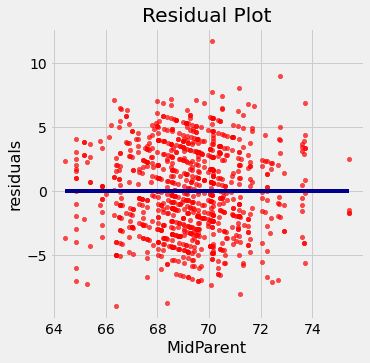

In [85]:
residual_plot(heights, 'MidParent', 'Child')

+ 증가나 감소의 경향이 보이지 않는다.
+ 이와 같은 분석을 _regression diagnostics_ 라 한다.
+ 좋은 residual은 어떤 패턴을 보이지 않아야 한다.
 - $y=0$ 선을 기준으로 위 아래가 비슷해야 한다. 
+ 그렇지 않은 사례를 살펴보자. 
 - 호주의 듀공(바다포유류의 일종)에 관한 데이터

In [86]:
dugong = Table.read_table('http://www.statsci.org/data/oz/dugongs.txt')
dugong = dugong.move_to_start('Length')
dugong

Length,Age
1.8,1
1.85,1.5
1.87,1.5
1.77,1.5
2.02,2.5
2.27,4
2.15,5
2.26,5
2.35,7
2.47,8


In [87]:
correlation(dugong, 'Length', 'Age')

0.8296474554905714

+ 매우 높은 상관계수값을 보인다.
+ 선형관계임이 당연한가?

In [0]:
def regression_diagnostic_plots(table, x, y):
    scatter_fit(table, x, y)
    residual_plot(table, x, y)

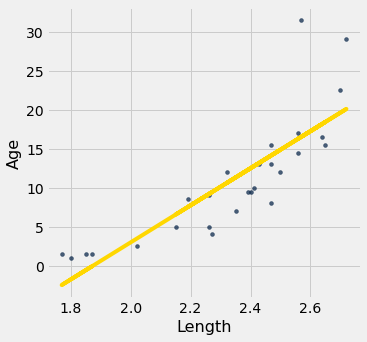

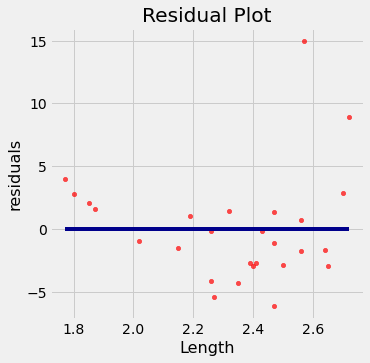

In [89]:
regression_diagnostic_plots(dugong, 'Length', 'Age')

+ nonlinearity (비선형) 관계가 의심된다.
+ 또 다른 사례를 살펴보자.

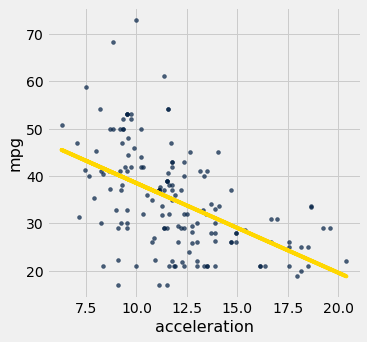

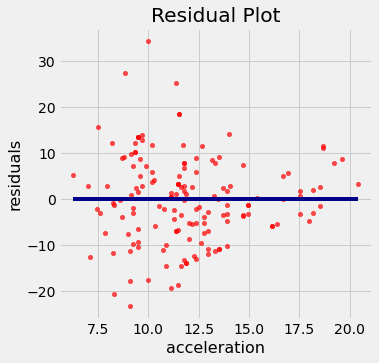

In [90]:
regression_diagnostic_plots(hybrid, 'acceleration', 'mpg')

+ accel. 이 작을 때 residual의 분산이 크고
+ accel. 이 클 때 residual의 분산이 작다.
+ 이를 Heteroscedasticity(이분산성)이라 하며 regression 정확성이 편차가 있음을 의미한다.

> ### Numerical Diagnostics
----
+ 앞서 residual diagnostics은 regression이 linear인지 여부와는 상관이 없다.
+ Residual 성질


For every linear regression, whether good or bad, the residual plot shows no trend. 
+ Overall, it is flat. In other words, the residuals and the predictor variable are uncorrelated.

In [91]:
correlation(heights, 'MidParent', 'Residual')

-2.719689807647064e-16

Average of Residuals


+ No matter what the shape of the scatter diagram, the average of the residuals is 0.

In [92]:
np.mean(heights.column('Residual'))

5.256799040794746e-15

SD of the Residuals (증명은 생략되어 있음)

+ No matter what the shape of the scatter plot, the SD of the residuals is a fraction of the SD of the response variable. The fraction is $\sqrt{1-r^2}$.

$$ \textrm{SD of residuals} = \sqrt{1-r^2} \cdot \textrm{SD of }y$$

+ 비슷한 방식으로

$$ \textrm{SD of fitted value} (\hat{y}) = |r| \cdot \textrm{SD of }y$$


In [93]:
np.std(heights.column('Residual'))

3.3880799163953426

In [94]:
r = correlation(heights, 'MidParent', 'Child')
np.sqrt(1 - r**2) * np.std(heights.column('Child'))

3.388079916395342

A relevant equation
 
+ $\frac{Var(\hat{y})}{Var(y)} = r^2 $

> ### Recap
---

+ Correlation
 - $r=E(XY)$ (단, $X, Y$는 standard units)
+ Regression Line
 - standard units : 기울기가 $r$이고 원점을 지나는 직선
 - original units
   - slope = $r \frac{\sigma_y}{\sigma_x}$
   - intercept = $\mu_y - slope \cdot \mu_x$
 - scatter()의 fit_line=True 설정으로 그릴 수 있다.
+ Least Squares Method (최소제곱법)
 - RMSE 최소화하는 직선
 - regression line = mean sqaures line
+ Least Squares Regression
 - error함수를 정의하고 minimize함수를 통해 최적화
+ Visual diagnostics
 - Residual의 분포가 nonlinearity, Heteroscedasticity 와 같은 아무런 패턴이 없어야 한다.